### Import the libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

import warnings
warnings.filterwarnings('ignore')

### Load the dataset

In [2]:
df = pd.read_csv(r'data/train.csv', usecols=['Age', 'Fare', 'Survived'])

In [3]:
df.head()

,Survived,Age,Fare
0,0,22.0,7.2500
1,1,38.0,71.2833
2,1,26.0,7.9250
3,1,35.0,53.1000
4,0,35.0,8.0500


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Age       714 non-null    float64
 2   Fare      891 non-null    float64
dtypes: float64(2), int64(1)
memory usage: 21.0 KB


In [5]:
df['Age'].fillna(df['Age'].mean(), inplace=True)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Age       891 non-null    float64
 2   Fare      891 non-null    float64
dtypes: float64(2), int64(1)
memory usage: 21.0 KB


In [7]:
df.skew()

Survived    0.478523
Age         0.434488
Fare        4.787317
dtype: float64

* 0 → perfectly symmetric (like a normal distribution)
* *> 0 → right-skewed (long tail on the right)
* < 0 → left-skewed (long tail on the left)

### Train Test Split

In [8]:
X = df.drop('Survived', axis=1)
y = df['Survived']

In [9]:
X.shape, y.shape

((891, 2), (891,))

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### QQ Plot

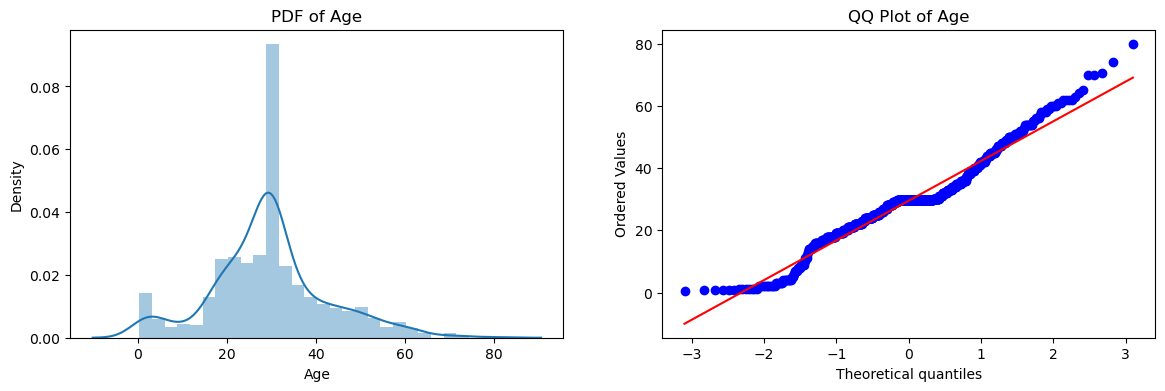

In [11]:
plt.figure(figsize=(14,4))
plt.subplot(121)
sns.distplot(X_train['Age'])
plt.title('PDF of Age')

plt.subplot(122)
stats.probplot(X_train['Age'], dist='norm', plot=plt)
plt.title('QQ Plot of Age');

* Age seems to be bit normallly distributed which can be seen from QQ plot.

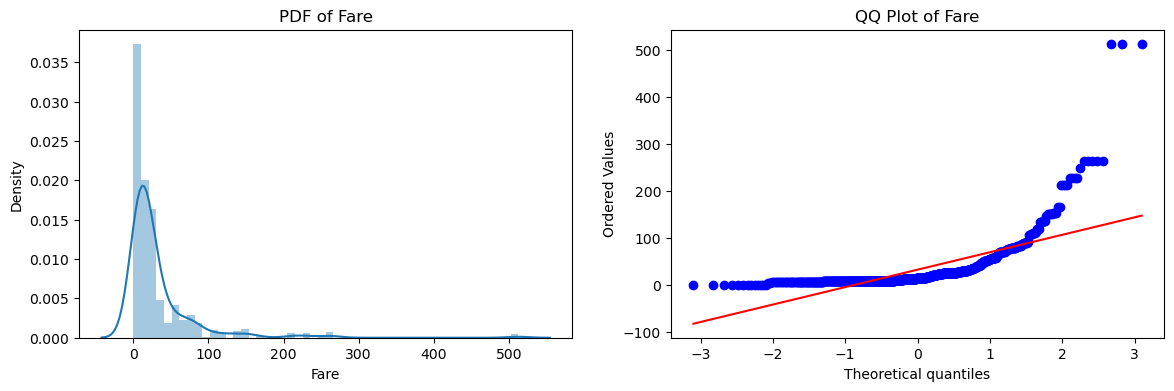

In [12]:
plt.figure(figsize=(14,4))
plt.subplot(121)
sns.distplot(X_train['Fare'])
plt.title('PDF of Fare')

plt.subplot(122)
stats.probplot(X_train['Fare'], dist='norm', plot=plt)
plt.title('QQ Plot of Fare');

* Fare is a right skewed.

### LogisticRegression and DecisionTree without FunctionTransformer

In [13]:
lr = LogisticRegression()
dt = DecisionTreeClassifier()

#### Fit the model

In [14]:
lr.fit(X_train, y_train)

LogisticRegression()

In [15]:
dt.fit(X_train, y_train)

DecisionTreeClassifier()

#### Prediction and Accuracy Score

In [16]:
y_pred_lr = lr.predict(X_test)
y_pred_dt = dt.predict(X_test)

print("Accuracy using Logistic Regression - ", accuracy_score(y_test, y_pred_lr))
print("Accuracy using Decision Tree - ", accuracy_score(y_test, y_pred_dt))

Accuracy using Logistic Regression -  0.6480446927374302
Accuracy using Decision Tree -  0.6536312849162011


### LogisticRegression and DecisionTree with FunctionTransformer

In [17]:
transformer = FunctionTransformer(func=np.log1p)
X_train_transformed = transformer.fit_transform(X_train)
X_test_transformed = transformer.transform(X_test)

#### Fit the model

In [18]:
lr = LogisticRegression()
dt = DecisionTreeClassifier()

In [19]:
lr.fit(X_train_transformed, y_train)

LogisticRegression()

In [20]:
dt.fit(X_train_transformed, y_train)

DecisionTreeClassifier()

#### Prediction and Accuracy Score

In [21]:
y_pred_lr = lr.predict(X_test_transformed)
y_pred_dt = dt.predict(X_test_transformed)

print("Accuracy using Logistic Regression - ", accuracy_score(y_test, y_pred_lr))
print("Accuracy using Decision Tree Classifier - ", accuracy_score(y_test, y_pred_dt))

Accuracy using Logistic Regression -  0.6815642458100558
Accuracy using Decision Tree Classifier -  0.6815642458100558


* As you can see the accuracy score of Logistic Regression has increased which tells that the log transform has helped.
* Whenever you see an improvement in the performance of the model, do a cross validation to verify that this improvement is legit, not due to over fitting.

#### Cross Validation

In [22]:
X_transformed = transformer.fit_transform(X)

lr = LogisticRegression()
dt = DecisionTreeClassifier()

print("Cross Validated Score for Logistic Regression - ", np.mean(cross_val_score(lr, X_transformed, y, scoring='accuracy', cv=10)))
print("Cross Validated Score for Decision Tree Classifier - ", np.mean(cross_val_score(dt, X_transformed, y, scoring='accuracy', cv=10)))

Cross Validated Score for Logistic Regression -  0.678027465667915
Cross Validated Score for Decision Tree Classifier -  0.6532584269662922


* Yeah, this is a legit improvement in the model performance.

#### QQ Plot before and after Log Transformation

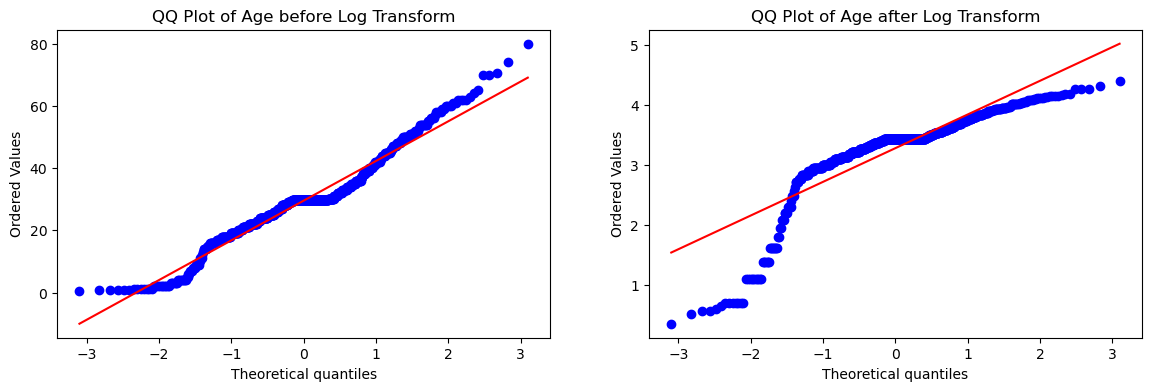

In [23]:
plt.figure(figsize=(14,4))
plt.subplot(121)
stats.probplot(X_train['Age'], dist='norm', plot=plt)
plt.title('QQ Plot of Age before Log Transform')

plt.subplot(122)
stats.probplot(X_train_transformed['Age'], dist='norm', plot=plt)
plt.title('QQ Plot of Age after Log Transform');

* Age ka distribution has become worse after the Log Transformation. (Age was not Right Skewed)

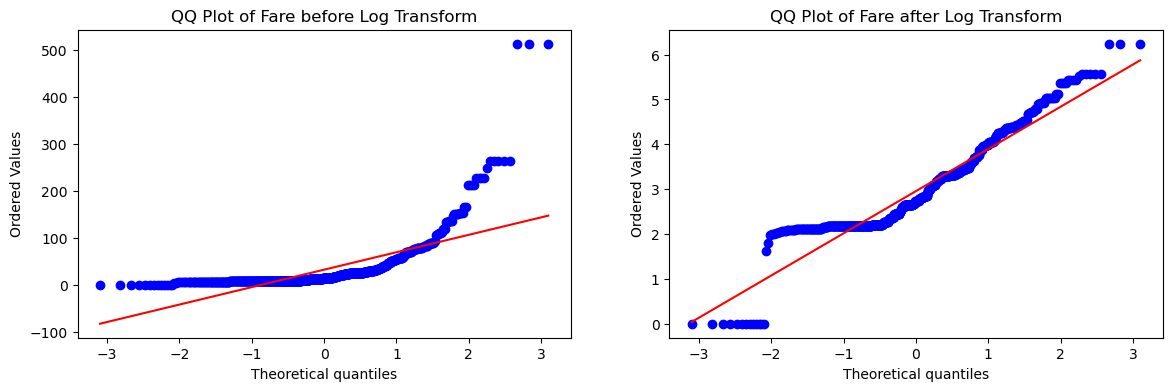

In [24]:
plt.figure(figsize=(14,4))
plt.subplot(121)
stats.probplot(X_train['Fare'], dist='norm', plot=plt)
plt.title('QQ Plot of Fare before Log Transform')

plt.subplot(122)
stats.probplot(X_train_transformed['Fare'], dist='norm', plot=plt)
plt.title('QQ Plot of Fare after Log Transform');

### Logistic Regression and DecisionTree using FunctionTransformer only on Fare column

In [25]:
transformer = ColumnTransformer(
    transformers=[
        ('Log Transform', FunctionTransformer(np.log1p), ['Fare'])
    ],
    remainder='passthrough',
    verbose_feature_names_out=True,
    verbose=True
)

In [26]:
X_train_transformed = transformer.fit_transform(X_train)
X_test_transformed = transformer.transform(X_test)

[ColumnTransformer] . (1 of 2) Processing Log Transform, total=   0.0s
[ColumnTransformer] ..... (2 of 2) Processing remainder, total=   0.0s


#### Fit the model

In [27]:
lr = LogisticRegression()
dt = DecisionTreeClassifier()

In [28]:
lr.fit(X_train_transformed, y_train)

LogisticRegression()

In [29]:
dt.fit(X_train_transformed, y_train)

DecisionTreeClassifier()

#### Prediction and Accuracy Scores

In [30]:
y_pred_lr = lr.predict(X_test_transformed)
y_pred_dt = dt.predict(X_test_transformed)

print("Accuracy using Logistic Regression - ", accuracy_score(y_test, y_pred_lr))
print("Accuracy using Decision Tree Classifier - ", accuracy_score(y_test, y_pred_dt))

Accuracy using Logistic Regression -  0.6703910614525139
Accuracy using Decision Tree Classifier -  0.659217877094972


#### Cross Validation

In [31]:
X_transformed = transformer.fit_transform(X)

lr = LogisticRegression()
dt = DecisionTreeClassifier()

print("Cross Validated Score for Logistic Regression - ", np.mean(cross_val_score(lr, X_transformed, y, scoring='accuracy', cv=10)))
print("Cross Validated Score for Decision Tree Classifier - ", np.mean(cross_val_score(dt, X_transformed, y, scoring='accuracy', cv=10)))

[ColumnTransformer] . (1 of 2) Processing Log Transform, total=   0.0s
[ColumnTransformer] ..... (2 of 2) Processing remainder, total=   0.0s
Cross Validated Score for Logistic Regression -  0.6712609238451936
Cross Validated Score for Decision Tree Classifier -  0.6554681647940075


### A genric function

In [32]:
def apply_transform(transform):
    X = df.iloc[:,1:3]
    y = df.iloc[:,0]
    
    trf = ColumnTransformer([('log',FunctionTransformer(transform),['Fare'])],remainder='passthrough')
    
    X_trans = trf.fit_transform(X)
    
    clf = LogisticRegression()
    
    print("Accuracy",np.mean(cross_val_score(clf,X_trans,y,scoring='accuracy',cv=10)))
    
    plt.figure(figsize=(14,4))

    plt.subplot(121)
    stats.probplot(X['Fare'], dist="norm", plot=plt)
    plt.title('Fare Before Transform')

    plt.subplot(122)
    stats.probplot(X_trans[:,0], dist="norm", plot=plt)
    plt.title('Fare After Transform')

    plt.show()

#### Sin Transform

Accuracy 0.6195131086142323


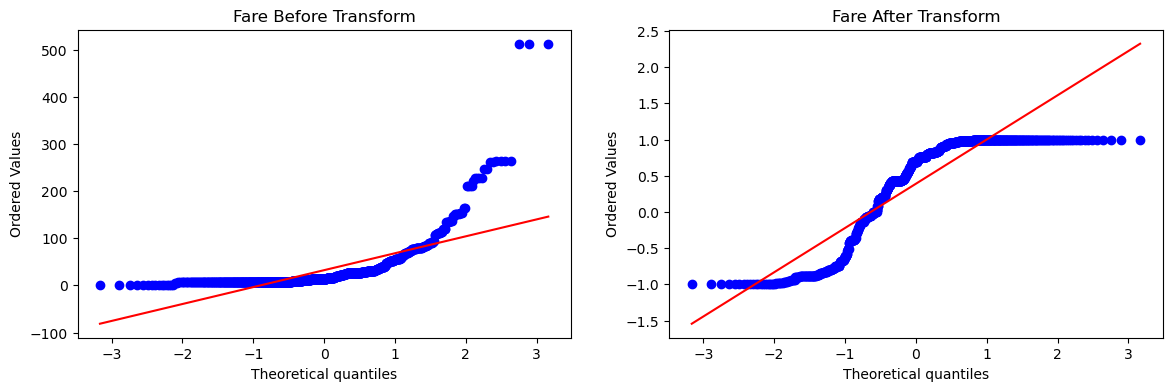

In [33]:
apply_transform(np.sin)

#### Square

Accuracy 0.6431335830212235


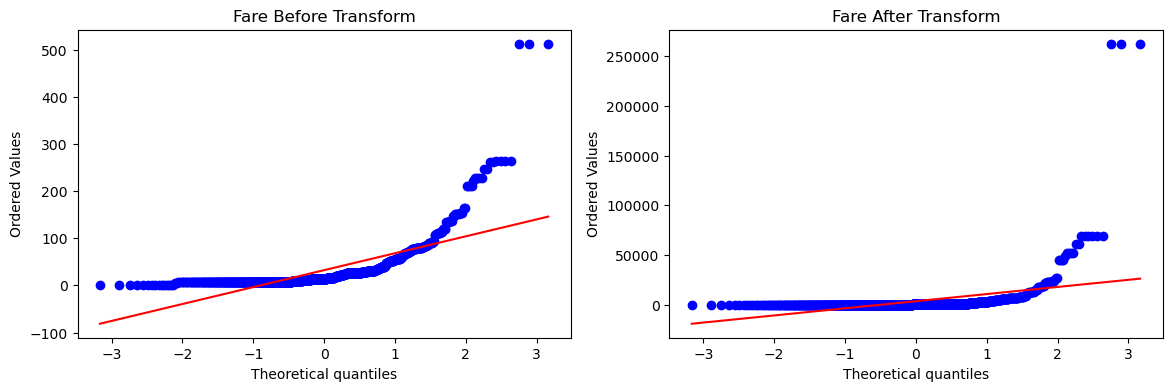

In [34]:
apply_transform(lambda x: x**2)

#### Cube

Accuracy 0.6262796504369538


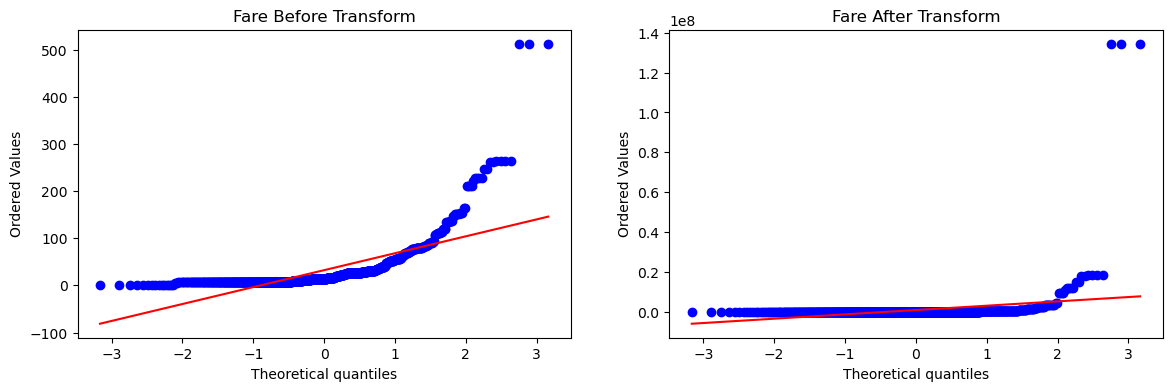

In [35]:
apply_transform(lambda x: x**3)

#### Square Root

Accuracy 0.6589013732833957


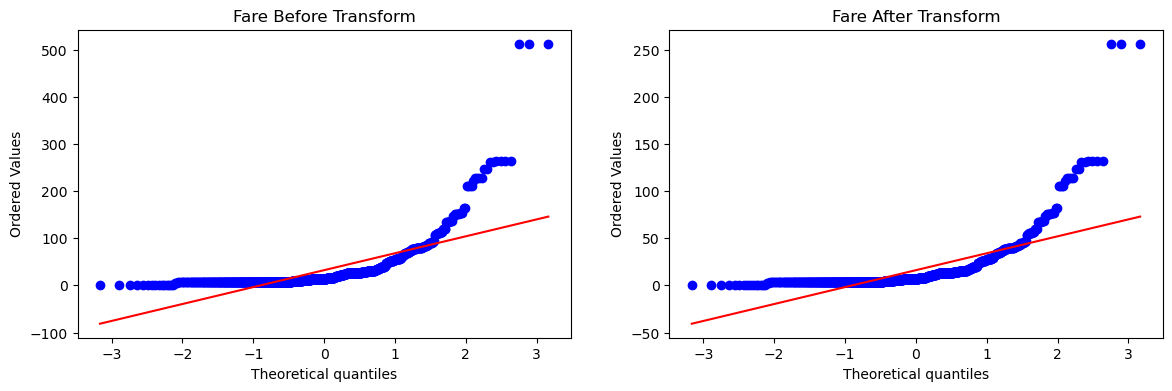

In [36]:
apply_transform(lambda x: x**1/2)

#### Reciprocal

Accuracy 0.61729088639201


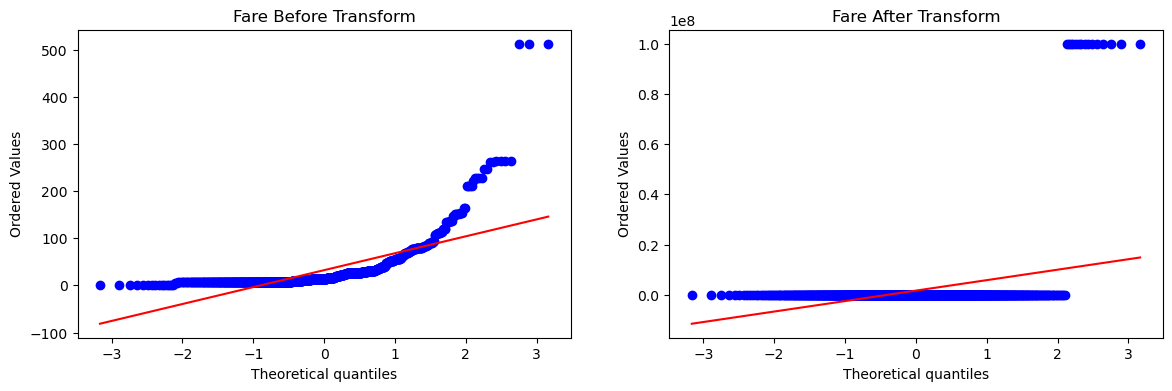

In [37]:
apply_transform(lambda x: 1/(x+0.00000001))